In [1]:
import pywatershed
import pandas as pd
import pathlib as pl
import json
import numpy as np
from pywatershed.parameters.prms_parameters import JSONParameterEncoder

import sys
sys.path.append('../scripts/')
from pest_utils import pars_to_tpl_entries
sys.path.append('../dependencies/')
import pyemu

interrupt_notebook = False

C:\Users\ahaj\nhm_pestpp\notebooks\../dependencies\pyemu\pst\pst_handler.py:15: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


In [2]:
all_models = ['01473000','05431486','09112500','14015000']# Create a list of all cutouts

In [3]:
rootdir = pl.Path('../NHM_extractions/20230110_pois_haj/')# Path to location of cutouts

In [4]:
cm = all_models[0] # sets cutout from list
pestdir = rootdir/ cm # stes path to location of NHM output folder where output files are.

In [5]:
pst = pyemu.Pst(str(pestdir / 'prior_mc.pst'))

error parsing metadata from 'obsnme', continuing


<Axes: >

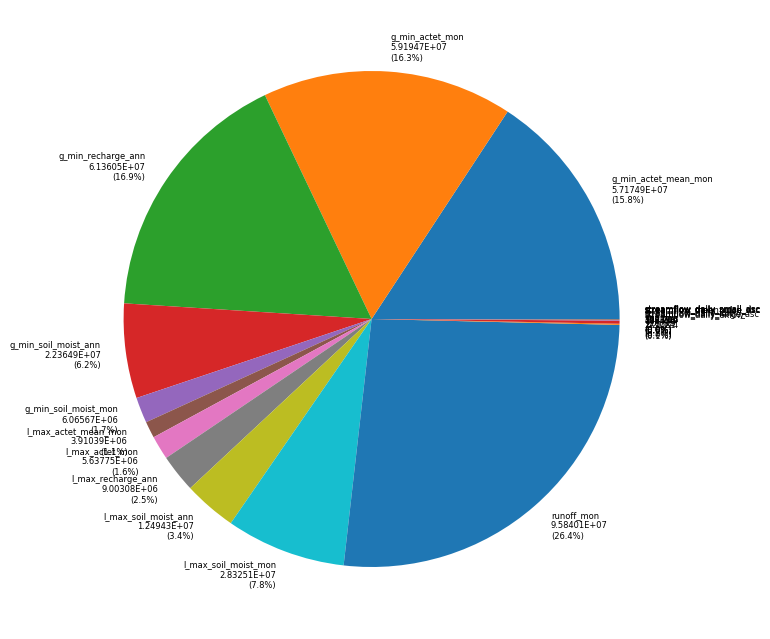

In [6]:
pst.plot(kind='phi_pie')

In [7]:
pst.phi_components

{'g_min_actet_mean_mon': 57174897.86004783,
 'g_min_actet_mon': 59194728.36382827,
 'g_min_recharge_ann': 61360472.10067078,
 'g_min_soil_moist_ann': 22364913.987959184,
 'g_min_soil_moist_mon': 6065673.947480659,
 'l_max_actet_mean_mon': 3910394.062980134,
 'l_max_actet_mon': 5637747.0959339505,
 'l_max_recharge_ann': 9003076.241704728,
 'l_max_soil_moist_ann': 12494345.787654553,
 'l_max_soil_moist_mon': 28325131.627276435,
 'runoff_mon': 95840082.63700613,
 'sca_daily': 0.0,
 'streamflow_daily_exlow': 271081.43545718776,
 'streamflow_daily_large_asc': 2.211740858638125,
 'streamflow_daily_low': 728714.7233065581,
 'streamflow_daily_pulse_asc': 188435.61616867472,
 'streamflow_daily_pulse_dsc': 173855.56071822825,
 'streamflow_daily_small_asc': 409.24897029681705,
 'streamflow_daily_small_dsc': 243.21636783214322,
 'streamflow_mean_mon': 597.7041815444596,
 'streamflow_mon': 15479.406845128055}

In [8]:
phi = pst.phi
phi

362750282.83629894

In [9]:
#stop

In [19]:
phi_new_comps = {'l_max_actet_mean_mon':0.05 * phi,
                 'g_min_actet_mean_mon':0.05 * phi,
                 'l_max_actet_mon':  .10 * phi,
                 'g_min_actet_mon':  .10 * phi,
                 'streamflow_nodata': 0 * phi,
                 'l_max_recharge_ann': 0.05 * phi,
                 'g_min_recharge_ann': 0.05 * phi,
                 'runoff_mon': .15 * phi,
                 'sca_daily':0 * phi,
                 'l_max_soil_moist_ann': 0.05 * phi,
                 'g_min_soil_moist_ann': 0.05 * phi,
                 'l_max_soil_moist_mon': 0.05 * phi,
                 'g_min_soil_moist_mon': 0.05 * phi,
                 'streamflow_mean_mon': .10 * phi,
                 'streamflow_mon': .15 * phi }

In [20]:
# add streamflow_daily components

#Changed above to '0' for now, rebalance above accordingly
stream_comps_perc = 0.0 #0.35 
stream_comps = len([i for i,_ in pst.phi_components.items() if i.lower().startswith('streamflow_daily')])
stream_comps_each_perc = stream_comps_perc / stream_comps

for i in pst.phi_components.keys():
    if i.lower().startswith('streamflow_daily'):
        phi_new_comps[i] = stream_comps_each_perc * phi

In [21]:
try:
    assert np.isclose(sum([i for _,i in phi_new_comps.items()])/phi, 1.0)
    print('Very very close to 1.0. Carry on!')
except:
    print('Not close to 1.0. Stop and recheck your weight for catagory.')

Very very close to 1.0. Carry on!


In [22]:
sum([i for _,i in phi_new_comps.items()])/phi

1.0

In [23]:
assert np.isclose(sum([i for _,i in phi_new_comps.items()])/phi, 1.0)

In [24]:
pst.obs_groups

['g_min_actet_mean_mon',
 'g_min_actet_mon',
 'g_min_recharge_ann',
 'g_min_soil_moist_ann',
 'g_min_soil_moist_mon',
 'l_max_actet_mean_mon',
 'l_max_actet_mon',
 'l_max_recharge_ann',
 'l_max_soil_moist_ann',
 'l_max_soil_moist_mon',
 'runoff_mon',
 'sca_daily',
 'streamflow_daily_large_asc',
 'streamflow_daily_small_asc',
 'streamflow_daily_small_dsc',
 'streamflow_daily_pulse_asc',
 'streamflow_daily_pulse_dsc',
 'streamflow_daily_low',
 'streamflow_daily_exlow',
 'streamflow_mean_mon',
 'streamflow_mon']

In [25]:
pst.adjust_weights(obsgrp_dict=phi_new_comps)

<Axes: >

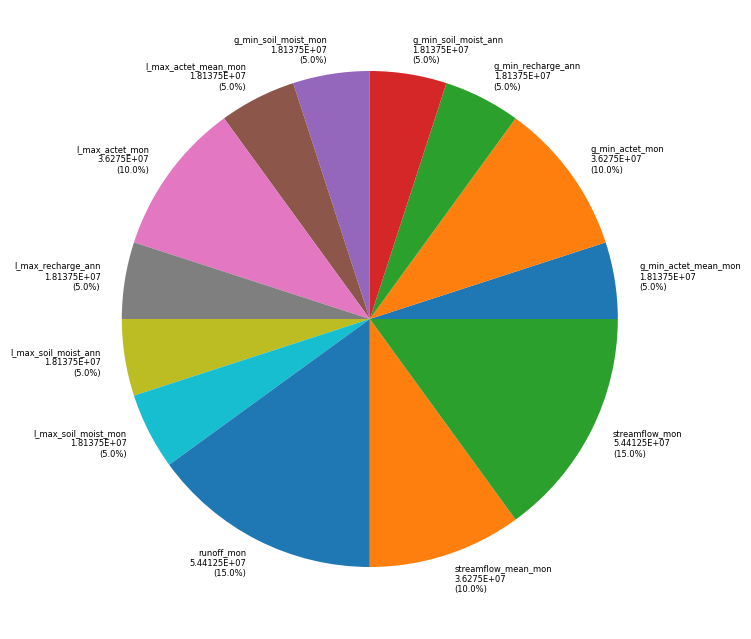

In [26]:
pst.plot(kind='phi_pie')

In [ ]:
pst.observation_data.loc[pst.observation_data.obgnme=='streamflow_nodata']

In [ ]:
#Write a new version of the PEST++ control file (.pst)
pst.write(str(rootdir/cm/ 'prior_mc_reweight.pst'), version=2)


In [ ]:
print(pst.adjust_weights(obsgrp_dict=phi_new_comps))


In [ ]:
#Write this to a dataframe (.csv) and save it somewhere so that we have a record of it. with time date and append to .csv every notebook run.
print(pst.phi_components_normalized)
